In [ ]:
from sklearn.svm import SVC
from util import info
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
plt.style.use(['dark_background'])

# import warnings
# warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:

xn = np.linspace(-.25,1.0,200)
xnn = xn[7:-10]

data = np.load(r"C:\Users\zfj\data\081122B\func\spots_smooth.npy")
data = np.moveaxis(data[:,:,7:-10],0,2)
# fdata = data.reshape(data.shape[0],-1)

labels = np.load(r"C:\Users\zfj\data\081122B\func\spots_labels.npy")
ue = np.array([
[-24.74181249, -24.74181249, -16.49454166, -16.49454166, -16.49454166,
   -8.24727083,  -8.24727083,   0.,           0.,           0.,
    8.24727083,   8.24727083,  16.49454166,  16.49454166,  16.49454166,
   24.74181249,  24.74181249],
[-14.2846921,   14.2846921,  -28.56938421,   0.,          28.56938421,
  -14.2846921,   14.2846921,  -28.56938421,   0.,          28.56938421,
  -14.2846921,   14.2846921,  -28.56938421,   0.,          28.56938421,
  -14.2846921,   14.2846921 ]]).T

In [ ]:
cv = StratifiedKFold(5, shuffle=True, random_state=0)
train, test = list(cv.split(data, labels))[0]
xtrain, xtest = data[train], data[test]
ytrain, ytest = ue[labels[train], None, :], ue[labels[test], None, :]
ltrain, ltest = labels[train], labels[test]

print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

In [ ]:
# mod = keras.Sequential()
# mod.add(layers.Input((None,170)))
# # mod.add(layers.BatchNormalization())

# mod.add(layers.LayerNormalization())
# mod.add(layers.Dense(256, activation='relu'))
# mod.add(layers.LayerNormalization())
# # mod.add(layers.SpatialDropout1D(.1))
# mod.add(layers.Dense(256, activation='relu'))
# # mod.add(layers.BatchNormalization())
# mod.add(layers.LayerNormalization())

# mod.add(layers.Dense(16, activation='relu'))
# # mod.add(layers.BatchNormalization())
# mod.add(layers.LayerNormalization())

# # mod.add(layers.Dropout(.1))
# mod.add(layers.Dense(2))
# mod.summary()

def ff_norm(input, ndims, skip=True, **kwargs):
    ffn = layers.Dense(ndims, **kwargs)(input)
    ffn = layers.LayerNormalization()(ffn)
    if skip:
        return layers.Concatenate()([input, ffn])
    else:
        return ffn



input = keras.layers.Input((None,170))
input_norm = layers.LayerNormalization()(input)

ffn1 = ff_norm(input_norm, 256, activation='softmax')
ffn2 = ff_norm(ffn1, 256, activation='softmax')
# ffn3 = ff_norm(ffn2, 16, skip=False)
ffn4 = layers.Dense(2)(ffn2)
mod = keras.Model(inputs=input, outputs = ffn4)

mod.summary()

In [ ]:
weight = np.zeros_like(xnn)
weight[xnn>0] = np.exp(-np.arange(np.count_nonzero(xnn>0))/10)+.05
weight[-10:] = weight.max()/3

weight /= weight.sum() 
weight *= len(xnn)

plt.plot(xnn, weight)

In [ ]:
def weighted_mse_loss(y_true,y_pred):
    ae = (y_true - y_pred) * tf.cast(weight[None,:,None], dtype=y_true.dtype)
    se = tf.math.reduce_sum(tf.square(ae), axis=-1)
    mse = tf.math.reduce_mean(se)#, axis=(0,1))
    
    return mse


mod.compile(loss=keras.losses.MeanSquaredError())
mod.compile(
    # loss=weighted_mse_loss,
    loss = keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)
history = mod.fit(xtrain, ytrain, validation_data=(xtest,ytest), epochs=100, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=4, verbose=1))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
rtrain = mod.predict(xtrain)
rtest = mod.predict(xtest)

In [ ]:
def dist(y_true,y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).sum(axis=-1))

d = dist(ytest, rtest)
se = d.std(axis=0)
plt.plot(xnn, d.mean(axis=0), label='Test')
plt.fill_between(xnn, d.mean(axis=0) + 3*se/np.sqrt(len(d)), d.mean(axis=0) - 3*se/np.sqrt(len(d)), alpha=.3)

d = dist(ytrain, rtrain)
se = d.std(axis=0)
plt.plot(xnn, d.mean(axis=0), label='Train')
plt.fill_between(xnn, d.mean(axis=0) + 3*se/np.sqrt(len(d)), d.mean(axis=0) - 3*se/np.sqrt(len(d)), alpha=.3)

plt.legend()

In [ ]:
inf = info.MI(ltest, ndims=2)
MI_t = np.asarray([inf.QE(rtest[:,t]) for t in range(183)])

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(xnn,MI_t)

ylim = plt.ylim()
plt.ylabel('Information (bits)')
plt.xlabel('Time (s)')

plt.axhline(0,0,1,color='w')

plt.gca().twinx()
plt.ylim(ylim / np.log2(17) * 100)
plt.ylabel('Information (% max.)')

print(max(MI_t), max(MI_t)/np.log2(17))

# plt.title('Cumulative Information')
#2.953610525400135 0.7226024162452415

In [ ]:
#transfer learning: extract the outputs of the second-to-last layer as features, and train the lstm on these
# mod.trainable = False

feature_mod = keras.Model(inputs= mod.input, outputs=ffn2)
# feature_mod = keras.Model(inputs= mod.input, outputs=mod.layers[-2].output)
ftrain = feature_mod.predict(xtrain)
ftest = feature_mod.predict(xtest)


In [ ]:
_,axs = plt.subplots(5,4,figsize=(20,20))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(ftrain[ltrain==i,60,:], aspect=15, interpolation='none')


In [ ]:
class AnnealingModel(keras.Model):
    def __init__(self, n_warmup_steps=310, anneal_rate = .1, anneal_duration=31*30, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_passes = tf.Variable(0., trainable=False)
        self.anneal_coeff = tf.Variable(1., trainable=False)
        self.anneal_rate = anneal_rate
        self.anneal_duration = anneal_duration
        self.n_warmup_steps = n_warmup_steps

    @tf.function
    def train_step(self, data):
        (x, y_hat), y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass

            # anneal y_pred...
            y_pred += y_hat * self.anneal_coeff

            # Compute loss
            loss = self.compiled_loss(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)

        # Anneal
        self.n_passes.assign(self.n_passes + 1.)
        if self.n_passes > self.n_warmup_steps:
            if self.n_passes > self.n_warmup_steps + self.anneal_duration:
                self.anneal_coeff.assign(0.)
            else:
                self.anneal_coeff.assign(tf.math.exp(-self.anneal_rate * (self.n_passes - self.n_warmup_steps)))

        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        
        print('Annealing is', self.anneal_coeff)
        # Unpack the data
        # Compute predictions
        if type(data) is tf.Tensor:
            x, y = data
            y_pred = self(x, training=False)
        else:
            (x,y_hat), y = data
            y_pred = self(x, training=False) + y_hat * self.anneal_coeff
            
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

In [129]:
# tm_mod = keras.Sequential()
# tm_mod.add(layers.Input((None,1024)))
# # tm_mod.add(layers.Dropout(.25))
# tm_mod.add(layers.LSTM(64, recurrent_dropout=.1, return_sequences=True))
# # tm_mod.add(layers.BatchNormalization())
# tm_mod.add(layers.LayerNormalization())
# tm_mod.add(layers.Dense(16, activation='relu'))
# # tm_mod.add(layers.BatchNormalization())
# tm_mod.add(layers.LayerNormalization())
# # tm_mod.add(layers.Dropout(.1))
# tm_mod.add(layers.Dense(2))
# tm_mod.summary()

def lstm_norm(input, ndims, skip=True, **kwargs):
    ffn = layers.LSTM(ndims, return_sequences=True, **kwargs)(input)
    ffn = layers.LayerNormalization()(ffn)
    if skip:
        return layers.Concatenate()([input, ffn])
    else:
        return ffn

def wavnet(input, nlayers, ndims_conv):#, ndims_a, ndims_out):
    ffns = []
    # input = layers.Conv1D(ndims_resid, 1)(input)
    for i in range(nlayers):
        cnv1 = layers.Conv1D(ndims_conv, 2, dilation_rate=2**i, padding='causal', activation='tanh')(input)
        cnv2 = layers.Conv1D(ndims_conv, 2, dilation_rate=2**i, padding='causal', activation='sigmoid')(input)
        ffn = layers.Multiply()([cnv1, cnv2])
        ffn = layers.Conv1D(input.shape[-1], 1)(ffn)
        input = layers.Add()([ffn, input])
        input = layers.Normalization()(input) #added...
        ffns.append(ffn)
    # output = layers.Concatenate()(ffns)
    output = layers.Add()(ffns)
    # output = layers.ReLU()(output)
    # output = layers.Conv1D(ndims_a, 1, activation='relu')(output)
    # output = layers.Conv1D(ndims_out, 1, activation='softmax')(output)
    
    output = layers.LayerNormalization()(output)
    return output

    


# tmfi = layers.Input((183,ffn2.shape[-1]))
tmri = layers.Input((None,170))
# tmri = layers.LayerNormalization()(tmri)

tmei = layers.Input((183, 2))

# cnv1 = layers.Concatenate()([tmfi, tmei])
ffns = []
cnv1 = tmri
# cnv0 = layers.Concatenate()([tmri, tmei])
# cnv1 = cnv0
for _ in range(2):
    for i in range(9):
        cnv1 = layers.SeparableConv1D(32, 2, dilation_rate=2**i, padding='causal')(cnv1)
        cnv1 = layers.LayerNormalization()(cnv1)
        cnv1 = layers.Activation('relu')(cnv1)
        cnv1 = layers.SeparableConv1D(170, 1)(cnv1)
        cnv1 = layers.LayerNormalization()(cnv1)
        # cnv1 = layers.Add()([cnv1, cnv0])
        cnv1 = layers.Add()([cnv1, tmri])
        ffns.append(cnv1)
    # cnv1 = layers.Concatenate()([*ffns, tmfi, tmei])
    # cnv1 = layers.Concatenate()([*ffns, tmri])
    # cnv1 = layers.Add()([*ffns, cnv0])
    cnv1 = layers.Add()([*ffns, tmri])
    # cnv1 = layers.Dense(128)(cnv1)
ffnt = layers.Activation('sigmoid')(cnv1)
# ffnt = layers.LayerNormalization()(ffnt)
ffnt = layers.Dense(2)(ffnt)

# cnv1 = layers.Concatenate()([layers.Conv1D(1, int(i), padding='causal', activation='softmax')(tmfi) for i in np.linspace(8.0, 128.0, 16)])
# cnv2 = layers.Concatenate()([layers.Conv1D(1, int(i), padding='causal', activation='relu')(tmri) for i in np.linspace(8.0, 128.0, 16)])

# cnv = layers.Concatenate()([cnv1, cnv2])
# cnv = layers.Normalization()(cnv1)

# ffnt = layers.Dense(16, activation='sigmoid')(cnv)
# ffnt = layers.Normalization()(ffnt)

# cnv1 = layers.LocallyConnected1D(16, 128, padding='causal', activation='softmax')(tmfi)
# cnv1 = layers.LayerNormalization()(cnv1)
# ffnt = layers.Dense(2)(cnv1)

# lstm = layers.LSTM(256, recurrent_dropout=.2, return_sequences=True, unroll=True)(tmfi)
# ffnt = layers.Dense(16, activation='relu')(lstm)
# ffnt = layers.LayerNormalization()(ffnt)
# ffnt = layers.Dense(2)(ffnt)

# ffnt = layers.Add()([ffnt, tmei])
# tm_mod = keras.Model(inputs=[tmfi, tmei], outputs = ffnt)

tm_mod = keras.Model(inputs=tmri, outputs = ffnt)
# tm_mod = keras.Model(inputs=[tmri, tmei], outputs = ffnt)
# tm_mod = keras.Model(inputs=tmri, outputs = ffnt)
# tm_mod = AnnealingModel(inputs=tmri, outputs = ffnt)

tm_mod.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, None, 170)]  0           []                               
                                                                                                  
 separable_conv1d_318 (Separabl  (None, None, 32)    5812        ['input_37[0][0]']               
 eConv1D)                                                                                         
                                                                                                  
 layer_normalization_858 (Layer  (None, None, 32)    64          ['separable_conv1d_318[0][0]']   
 Normalization)                                                                                   
                                                                                           

In [130]:
tm_mod.compile(
    # loss=weighted_mse_loss,
    loss = keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    # optimizer=keras.optimizers.SGD(learning_rate=0.002),
)
# tm_history = tm_mod.fit(ftrain, ytrain, validation_data=(ftest,ytest), epochs=200, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=5, verbose=1))
# tm_history = tm_mod.fit(xtrain, ytrain, validation_data=(xtest,ytest), epochs=200, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=5, verbose=1))
# tm_history = tm_mod.fit((xtrain,ftrain,rtrain), ytrain, validation_data=((xtest,ftest,rtest),ytest), epochs=200, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=5, verbose=1))
# tm_history = tm_mod.fit((ftrain,rtrain), ytrain, validation_data=((ftest,rtest),ytest), epochs=200, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=5, verbose=1))
# tm_history = tm_mod.fit((xtrain,rtrain), ytrain, validation_data=((xtest,rtest),ytest), epochs=40)
# tm_history2 = tm_mod.fit((xtrain,rtrain), ytrain, validation_data=((xtest,rtest),ytest), epochs=200, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=5, verbose=1))
tm_history2 = tm_mod.fit(xtrain, ytrain, validation_data=(xtest,ytest), epochs=200, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=20, verbose=1))



Epoch 1/200
31/31 [==============================] - 84s 3s/step - loss: 316.9318 - val_loss: 298.6686
Epoch 2/200
31/31 [==============================] - 38s 1s/step - loss: 273.1582 - val_loss: 246.8724
Epoch 3/200
31/31 [==============================] - 115s 4s/step - loss: 229.7499 - val_loss: 216.1006
Epoch 4/200
31/31 [==============================] - 151s 5s/step - loss: 201.1048 - val_loss: 194.0794
Epoch 5/200
31/31 [==============================] - 144s 5s/step - loss: 182.2228 - val_loss: 176.6620
Epoch 6/200
31/31 [==============================] - 142s 5s/step - loss: 165.8888 - val_loss: 160.8446
Epoch 7/200
31/31 [==============================] - 129s 4s/step - loss: 151.5217 - val_loss: 150.7379
Epoch 8/200
31/31 [==============================] - 149s 5s/step - loss: 143.1317 - val_loss: 142.4742
Epoch 9/200
31/31 [==============================] - 146s 5s/step - loss: 134.1577 - val_loss: 137.3519
Epoch 10/200
31/31 [==============================] - 164s 5s/step

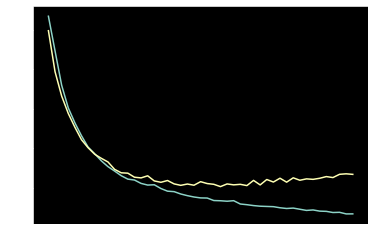

In [132]:
# tm_mod.n_passes, tm_mod.anneal_coeff, tm_mod.n_warmup_steps
# plt.plot([*tm_history.history['val_loss'], *tm_history2.history['val_loss']])
plt.plot(tm_history2.history['loss'])
plt.plot(tm_history2.history['val_loss'])

# plt.twinx()
# plt.plot(np.nan)
# plt.plot(np.concatenate((np.ones(10), np.exp(-.1*np.arange(30)), np.zeros(len(tm_history.history['val_loss'])+len(tm_history2.history['val_loss'])))))
# np.ones(10),np.exp(-.2*np.arange(10)),np.zeros(len(tm_history.history['val_loss'])+len(tm_history2.history['val_loss']))

8/8 [==============================] - 5s 435ms/step


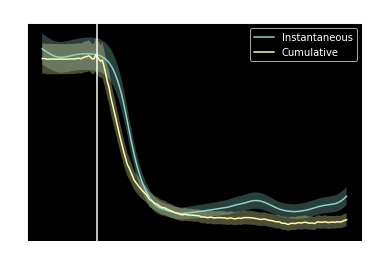

In [133]:
# rctest = tm_mod.predict((xtest,ftest,rtest))
# rctest = tm_mod.predict((ftest,rtest))
# rctest = tm_mod.predict((xtest,rtest))
rctest = tm_mod.predict(xtest)

d = dist(ytest, rtest)
se = d.std(axis=0)
plt.plot(xnn, d.mean(axis=0), label='Instantaneous')
plt.fill_between(xnn, d.mean(axis=0) + 3*se/np.sqrt(len(d)), d.mean(axis=0) - 3*se/np.sqrt(len(d)), alpha=.3)


d = dist(ytest, rctest)
se = d.std(axis=0)
plt.plot(xnn, d.mean(axis=0), label='Cumulative')
plt.fill_between(xnn, d.mean(axis=0) + 3*se/np.sqrt(len(d)), d.mean(axis=0) - 3*se/np.sqrt(len(d)), alpha=.3)

plt.legend()

x = plt.xlim()
dx = xnn[1]-xnn[0]
plt.twiny()
plt.xlim(x[0]/dx, x[1]/dx)
# plt.legend(['Instantaneous', 'Cumulative'])
plt.axvline(0,0,1,c='w')


In [134]:
inf = info.MI(ltest, ndims=2)
MI_t = np.asarray([inf.QE(rtest[:,t], nreps=50, nsamps=8) for t in range(183)])
MI_c = np.asarray([inf.QE(rctest[:,t], nreps=50, nsamps=8) for t in range(183)])

c:\Users\zfj\code\functionalimaginganalysis\python\util\info.py:38: RuntimeWarning: divide by zero encountered in log2
  HR = -np.nansum(self.Py * np.log2(self.Py))
c:\Users\zfj\code\functionalimaginganalysis\python\util\info.py:38: RuntimeWarning: invalid value encountered in multiply
  HR = -np.nansum(self.Py * np.log2(self.Py))
c:\Users\zfj\code\functionalimaginganalysis\python\util\info.py:39: RuntimeWarning: divide by zero encountered in log2
  HRS = -np.nansum(self.Py_x * np.log2(self.Py_x) * self.stim_prob)
c:\Users\zfj\code\functionalimaginganalysis\python\util\info.py:39: RuntimeWarning: invalid value encountered in multiply
  HRS = -np.nansum(self.Py_x * np.log2(self.Py_x) * self.stim_prob)
c:\Users\zfj\code\functionalimaginganalysis\python\util\info.py:55: RuntimeWarning: divide by zero encountered in log2
  HRS_ind = -np.nansum(Py_x_ind * np.log2(Py_x_ind) * self.stim_prob)
c:\Users\zfj\code\functionalimaginganalysis\python\util\info.py:55: RuntimeWarning: invalid value enc

3.079260935211562 0.7533428571229844
3.430407402777731 0.8392510307759476
0.23671651895757062 0.057912824691308984
0.22110552763819097


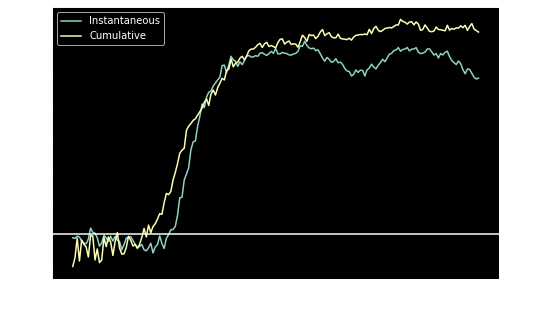

In [136]:
plt.figure(figsize=(8,5))
plt.plot(xnn,MI_t)
plt.plot(xnn,MI_c)
# plt.plot(MI_t)
# plt.plot(MI_c)

plt.legend(['Instantaneous', 'Cumulative'])

ylim = plt.ylim()
plt.ylabel('Information (bits)')
plt.xlabel('Time (s)')

plt.axhline(0,0,1,color='w')

plt.gca().twinx()
plt.ylim(ylim / np.log2(17) * 100)
plt.ylabel('Information (% max.)')

print(max(MI_t), max(MI_t)/np.log2(17))
print(max(MI_c), max(MI_c)/np.log2(17))

print(max(MI_t[xnn>0.05] - MI_c[xnn>0.05]), max(MI_t[xnn>0.05] - MI_c[xnn>0.05])/np.log2(17))
print(xnn[xnn>0.05][np.argmax(MI_t[xnn>0.05] - MI_c[xnn>0.05])])

# plt.title('Cumulative Information')


In [ ]:
#mods[0].get_weights()[3:6]
# inputs weights (n_inputs - by - 4 * n_outputs)
# recurrent weights (n_outputs - by - 4 * n_outputs)
# biases (4 * n_outputs)

#tm_mod
#mod
mod.summary()
# len(mod.get_weights())